In [2]:
from functools import reduce
import pathlib
import pandas as pd 
import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from adjustText import adjust_text # https://stackoverflow.com/questions/34693991/repel-annotations-in-matplotlib

# sys.path.append('/rumi/shams/abe/CanDI/')
sys.path.append('/data_gilbert2/backups/aarab/CanDI')

from CanDI import candi as can

In [3]:
sys.path.append('..')

from scripts.candi_functions import *

In [4]:
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats('svg')


# 

In [5]:
from venn import venn 

In [6]:
wd = '/data_gilbert/home/aarab/AML/Decitabine-treatment'

In [8]:
from scripts.util import *

In [9]:
aml = can.Cancer("Leukemia", subtype='AML')

# Number of Leukemia lines
print(len(aml.depmap_ids))

54


In [10]:
our_aml_panel = can.data.cell_lines[can.data.cell_lines.cell_line_name.isin([
    "SKM-1","MOLM-13",'HL-60',
    'MOLM-14','OCI-AML3','KG-1'
])].cell_line_name.to_dict()

In [11]:
# lu.depmap_ids
can.data.cell_lines.loc[
    can.data.cell_lines.cell_line_name.isin(our_aml_panel.values()),:
].set_index('cell_line_name')[['Subtype']]

,Subtype
cell_line_name,
HL-60,"Acute Myelogenous Leukemia (AML), M3 (Promyelo..."
OCI-AML3,"Acute Myelogenous Leukemia (AML), M4 (Myelomon..."
MOLM-13,Acute Myelogenous Leukemia (AML)
SKM-1,Acute Myelogenous Leukemia (AML)
KG-1,Acute Myelogenous Leukemia (AML)
MOLM-14,Acute Myelogenous Leukemia (AML)


# 

In [12]:
not_aml = can.CellLineCluster(list(set(can.data.cell_lines.index) - set(aml.depmap_ids)))

In [13]:
candi = can.CellLineCluster(can.data.cell_lines.index.to_list())

## expression

In [15]:
import pandas as pd
import numpy as np

In [16]:
from pydeseq2.preprocessing import deseq2_norm, deseq2_norm_fit, deseq2_norm_transform

In [17]:
gene_panel = [
    # 'TP53',
    'FTO','ALKBH5',
    'DCK', 'SLC29A1', 'BCL2', 'MCL1',
    'DCPS', 'DCP2', 'DCP1A', 'SCAF8',
    'METTL3', 'YTHDF2', 'YTHDC1', 'ZC3H13', 'VIRMA',#'KIAA1429', 
    'CBLL1',
    'PTEN', 'SQLE', 'INTS5', 'DHODH', 'MYBBP1A',
    'INO80D', 'PMPCA', 'ZNF777', 'SLC7A6', 'RNF126', 'RBM14-RBM4',
]

In [18]:
aml_exp = aml.rnaseq_reads

aml_exp_norm = deseq2_norm(np.log1p(aml_exp.T))[0].T

rnaseq_reads has not been loaded. Do you want to load, y/n?>  y


Load Complete


In [19]:
aml_exp.max().max()

12978000.0

In [20]:
aml_exp_norm.max().max()

15.358628608876638

### DHODH gene effect

https://forum.depmap.org/t/depmap-genetic-dependencies-faq/131
> The “gene effect” file contains the corrected CERES scores, which measure the effect size of knocking out a gene, normalized against the distributions of non-essential and pan-essential genes. The probabilities assess, given a gene score, how likely to be a member of the non-essential distribution or the common essential distribution in that cell line. The key difference between using a fixed threshold on CERES score and a threshold on the probabilities is that the probabilities take into account the screening quality, which varies from line to line.

In [52]:
gene_name = 'DHODH'

In [60]:
dep_df = pd.DataFrame({'dependency':candi.effect_of(gene_name)})
dep_df['primary_disease'] = can.data.cell_lines['primary_disease'][dep_df.index.to_list()]
dep_df=dep_df[~dep_df.primary_disease.eq('Non-Cancerous')]

dep_df['primary_disease'] = pd.Categorical(
    dep_df['primary_disease'], categories=dep_df.groupby('primary_disease')['dependency'].median().sort_values(ascending=True).index
)

dep_df['name'] = [our_aml_panel[cl] if cl in our_aml_panel.keys() else 'other' for cl in dep_df.index]

In [61]:
dep_df.query('name != "other"')

,dependency,primary_disease,name
ACH-000336,-0.492481,Leukemia,OCI-AML3
ACH-000362,-0.746526,Leukemia,MOLM-13
ACH-001574,-0.867626,Leukemia,MOLM-14


In [64]:
dep_df['Leukemia'] = dep_df.primary_disease == 'Leukemia'

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/candi-kg/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/candi-kg/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/candi-kg/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


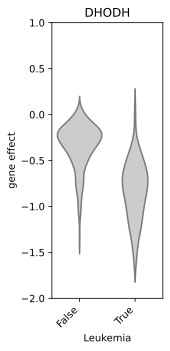

In [79]:
fig, ax = plt.subplots(figsize=(2,5))

sns.violinplot(
    data=dep_df, 
    x='Leukemia',y="dependency",inner=None, color=".8", fill=False,
    ax=ax
)

# sns.stripplot(
#     data=dep_df.query('name != "other"').copy(), 
#     jitter=True,x="Leukemia", y="dependency", size=10,linewidth=.3,
#     hue="name", alpha=.8,
#     ax=ax
# )

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_ylim(bottom=-2,top=1)

ax.set_title(gene_name)
ax.set_ylabel('gene effect')
# plt.savefig('aml-panel-gene-expression.pdf')
plt.show()

# Our CRISPRi screens
DNMT1 inhibitor drugs 

In [ ]:
# scrns = load_data(screens=True,wd=wd)

In [ ]:
# scrns.keys()

In [ ]:
# res,sen = find_top(scrns['hl60_exp1_DAC_rho'].astype(float), 
#          'rho score',0.2,
#          'Mann-Whitney p-value',0.01)

In [ ]:
# '","'.join(sen.index.to_list())

In [ ]:
# df = scrns['hl60_exp1_DAC_rho'].astype(float)

In [ ]:
# rho_df = merge_screen_data('hl60', ['exp1','exp2'], ['GSK','DAC'], 'rho', data=scrns)

# Our meRIP-seq data

In [ ]:
hl60_RNAme_df = pd.read_csv('meRIP-seq/radar/result.sig.txt',sep='\t')

In [ ]:
hl60_RNAme_df[hl60_RNAme_df.name.isin(['MAT1A', 'MAT2A', 'MAT2B','METTL14'])]

In [ ]:
# genes1 = genes.copy()
# genes2 = genes.copy()

# genes1['hyper_m6A'] = set(m6A_hl60_df[
#     (m6A_hl60_df.logFC > 2) & (m6A_hl60_df.p_value < 0.001)
# ].name.tolist())

# genes2['hypo_m6A']  = set(m6A_hl60_df[
#     (m6A_hl60_df.logFC < -2) & (m6A_hl60_df.p_value < 0.001)
# ].name.tolist())

In [ ]:
# fontsize=8

# # Set up the plot
# f, (ax1,ax2) = plt.subplots(1,2,figsize=(8,5))

# venn(genes1,fontsize=fontsize,legend_loc="lower left",ax=ax1)
# ax1.set_title('\n\nDecitabine', size = 15)

# # Set up the plot
# venn(genes2,fontsize=fontsize,legend_loc="lower right",ax=ax2)
# ax2.set_title('\n\nDMSO', size = 15)

# f.suptitle("HL60 DNA & RNA methylation genes",fontsize = 25)
# plt.tight_layout()
# f.subplots_adjust(wspace=0, hspace=0)
# plt.show()

In [ ]:
# reduce(set.intersection, (set(val) for val in genes1.values()))

In [ ]:
# reduce(set.intersection, (set(val) for val in genes2.values()))

In [ ]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))


def pretty_print_attr(obj):
    attr = []
    ls_attr = []
    meth = []
    for i in dir(obj):
        if "_" != i[0]:
            if type(getattr(obj, i)) == str or type(getattr(obj, i)) == int:
                attr.append(i)
            elif type(getattr(obj, i)) == list:
                ls_attr.append(i)
            else:
                meth.append(i)

    print("Attributes:\n")
    for i in attr: print(i+":", getattr(obj, i))
    for i in ls_attr: print(i+" list first item:", getattr(obj, i)[0])
    for i in ls_attr: print(i+" length:", len(getattr(obj, i)))
    print("\nMethods:\n")
    for i in meth: print(i)

In [ ]:
def mt_wt_objs(cancer, genes):
    # Cell lines with mutation
    mt_list = cancer.mutated(genes)
    mt = can.CellLineCluster(mt_list) 

    # CellLineCluster ojbect must be instantiated with a mutable sequence
    # I use set operations to get wild type cell line ids and convert to a list
    wt_list = list(set(lu.depmap_ids) - set(mt_list)) 

    wt = can.CellLineCluster(wt_list) 
    print (f'#of mutated cell lines:\n\t{len(mt.depmap_ids)}')
    print (f'#of wildtype cell lines:\n\t{len(wt.depmap_ids)}')
    
    return mt, wt

In [ ]:
def gene_effect_heatmap(obj1, obj2, genes, name = None):
    #Make Figure appropriate size, dpi, and font
    plt.rcParams.update({"figure.figsize": (16, 6),
                        "savefig.dpi": 300,
                        "font.size": 12
                        })

    #One figure with one subplot
    fig, ax = plt.subplots(1,1)

    #Construcat matrix to make heatmap and cell line labels
    data = pd.concat([obj1.effect_of(genes), obj2.effect_of(genes)], axis=1)
    names = can.data.cell_lines.loc[data.columns, "cell_line_name"]

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(names)))
    ax.set_yticks(np.arange(len(genes)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(names)
    ax.set_yticklabels(genes)

    #make heatmap
    im = ax.imshow(data, cmap="RdBu")

    #Make colorbar scale to axis
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = ax.figure.colorbar(im, ax = ax, cax = cax)
    cbar.ax.set_ylabel("Gene Effect", rotation=-90, va="bottom")

    #Draw Dividing line btween mutant and
    ax.axvline(x=obj1.gene_effect.shape[1] - 0.5, c = "black", linewidth = 3)
    plt.setp(ax.get_xticklabels(), rotation=-90, ha="left", va="center",
         rotation_mode="anchor")
    plt.tight_layout()
    plt.show()

    if name:
        fig.savefig(name, dpi=300)

        
def gene_effect_scatter(mt, wt, genes=None, name_scatter='', return_effect=False, plot=True, name=None):

    # Average Gene Effect 
    mt_effect = mt.gene_dependency.mean(1)
    wt_effect = wt.gene_dependency.mean(1)

    if return_effect:
        return mt_effect, wt_effect
    
    if plot:
        #Make Figure appropriate size, dpi, and font
        plt.rcParams.update({"figure.figsize": (8, 8),
                            "savefig.dpi": 300,
                            "font.family": "sans-serif",
                            "font.size": 12
                            })

        #Generate Figure and Axis objects
        fig, ax = plt.subplots(1,1)

        #Label Axes
        ax.set_xlabel(f"{name_scatter} MT Average Gene Effect (CERES Score)")
        ax.set_ylabel(f"{name_scatter} WT Average Gene Effect (CERES Score)")

        #Draw Line at median common essential value
        ax.axhline(y = 0.50,
                   c = "black",
                   linewidth=0.5,
                   label = "Minimun Gene Dependencey Probability"
                  )

        ax.axvline(x = 0.50,
                   c= "black",
                   linewidth=0.5)

        #Plot all genes
        ax.scatter(mt_effect,
                   wt_effect,
                   c = "#2166ac",
                   alpha = 0.1,
                   s = 50
                  )

        ax.legend()

        if genes:
            #For Labeling
            if type(genes) != list:
                mt_lab = mt_effect.loc[[genes]]
                wt_lab = wt_effect.loc[[genes]]
            else:
                mt_lab = mt_effect.loc[genes]
                wt_lab = wt_effect.loc[genes]
            # Outline Genes To label
            ax.scatter(mt_lab,
                       wt_lab,
                       c = "#2166ac",
                       s = 50,
                       edgecolor = "black",
                       linewidth = 2,
                       alpha = 0.7
                      )
        #     for i in range(mt_lab.shape[0]):
        #         text = list(mt_lab.index)
        #         ax.annotate(text[i],
        #                     xy = (mt_lab[i], wt_lab[i]),
        #                     xytext = label[i],
        #                     xycoords = "data",
        #                     arrowprops = {"arrowstyle": "-"}
        #                    )
            texts = []
            for x, y, s in zip(mt_lab, wt_lab, mt_lab.index.tolist()):
                texts.append(plt.text(x, y, s))

            adjust_text(
                texts, force_points=0.2, force_text=0.2,
                expand_points=(2, 2), 
                expand_text=(2, 2),
                arrowprops=dict(arrowstyle="-", color='black', lw=0.2)
            )

        plt.show()

        if name:
            fig.savefig(name, dpi=300)


In [ ]:
cell_lines = can.data.cell_lines
genes = can.data.genes.index.tolist()

m6A = pd.read_csv('m6A-genes.tsv',sep='\t')
m6A_genes = [g.split(' ')[0] for g in m6A.Names if g in genes]

DNMT_genes = [g for g in genes if 'DNMT' in g]

In [ ]:
set(m6A.Type)

In [ ]:
m6A_writer_genes = [g.split(' ')[0] for g in m6A[m6A.Type == 'm6A writer'].Names if g in genes] 
m6A_eraser_genes = [g.split(' ')[0] for g in m6A[m6A.Type == 'm6A eraser'].Names if g in genes] 

In [ ]:
can.data.mutations.columns

In [ ]:
list(set(can.data.mutations.Protein_Change))[1:10]

### Analyzing Global Gene Dependency


> #### [Note-about-Gene-Effect-Scores:-Dependency-vs-Essentiality:](https://candi.readthedocs.io/en/latest/kras_egfr_scatter.html#Note-about-Gene-Effect-Scores:-Dependency-vs-Essentiality) 
A more negative gene effect means more dependent. A gene effect of -1.0 is the median gene effect of all common essential genes. If a gene has a gene effect of -1.0 or lower it then that gene is essential. A cell line can still be dependent on a gene with a lower gene effect if knocking out that gene slows growth/proliferation.



### m6A writer mutation

In [ ]:
m6A_mt, m6A_wt = mt_wt_objs(lu, m6A_writer_genes + ['TP53'])

In [ ]:
gene_effect_heatmap(m6A_mt, m6A_wt,m6A_writer_genes + DNMT_genes)

In [ ]:
m6A_mt_effect, m6A_wt_effect = gene_effect_scatter(
    m6A_mt, m6A_wt,return_effect=True,plot=False
)

labels = intersection (
    m6A_mt_effect[m6A_mt_effect <= 0.45].index.tolist(),m6A_wt_effect[m6A_wt_effect >= 0.7].index.tolist()
) + intersection (m6A_mt_effect[m6A_mt_effect >= 0.65].index.tolist(),m6A_wt_effect[m6A_wt_effect <= 0.3].index.tolist())

gene_effect_scatter(
    m6A_mt, m6A_wt,
    genes=labels + ['DNMT1'] + ['INTS5'] + 
    [g for g in m6A_writer_genes if g in m6A_mt_effect.index.tolist()],
    name_scatter='m6A writer',
    name='DNA-RNA-mtyl-m6A-scatter.pdf'
)

run_enrichment(labels)

### INTS5 or m6A writer mutation

In [ ]:
mt, wt = mt_wt_objs(lu, m6A_writer_genes+['INTS5','TP53'])

In [ ]:
# gene_effect_heatmap(DNMT_mt, DNMT_wt,m6A_writer_genes + DNMT_genes)

In [ ]:
mt_effect, wt_effect = gene_effect_scatter(
    mt, wt,return_effect=True,plot=False
)

labels = intersection (
    mt_effect[mt_effect < 0.35].index.tolist(),wt_effect[wt_effect > 0.65].index.tolist()
) + intersection (mt_effect[mt_effect > 0.7].index.tolist(),wt_effect[wt_effect < 0.4].index.tolist())

gene_effect_scatter(
    mt, wt,
    genes=labels + ['DNMT1'] + ['INTS5', 'SQLE'] +
    [g for g in m6A_writer_genes if g in mt_effect.index.tolist()],
    name_scatter='DNMT family',
#     name='DNA-RNA-mtyl-DNmt-scatter.pdf'
)

run_enrichment(labels)

### DESeq analysis

In [ ]:
def make_counts_coldata(obj1, obj2, condition, factor1, factor2):

    counts1 = obj1.rnaseq_reads
    coldat1 = pd.Series(counts1.shape[1] * [factor1], index = counts1.columns, name = condition)

    counts2 = obj2.rnaseq_reads
    coldat2 = pd.Series(counts2.shape[1] * [factor2], index = counts2.columns, name = condition)

    #Concatenate Column Data
    coldat = pd.concat([coldat1, coldat2], axis = 0)
    #Concatenate read count data
    counts_mat = pd.concat([counts1, counts2], axis = 1)
    #Sum duplicate indeces
    counts_mat = counts_mat.groupby(counts_mat.index).sum().astype(int)

    return counts_mat, coldat

In [ ]:
counts_mat, coldat = make_counts_coldata(m6A_mt, m6A_wt,'mutation','mt','wt')

In [ ]:
coldat[coldat == 'mt']

## CCLE DNA Methylation data

HL-60 raw data - https://trace.ncbi.nlm.nih.gov/Traces/sra/?run=SRR8633931

In [ ]:
depmap_data_path = str(pathlib.Path(can.__file__).resolve().parent.parent)+'/setup/data/depmap'

cgi_CpG_clusters = pd.read_csv(
    f'{depmap_data_path}/CCLE_RRBS_cgi_CpG_clusters_20181119.txt.gz',
    sep='\t', quotechar='"',low_memory=False
)

enh_CpG_clusters = pd.read_csv(
    f'{depmap_data_path}/CCLE_RRBS_enh_CpG_clusters_20181119.txt.gz',
    sep='\t', quotechar='"',low_memory=False
)

tss_CpG_clusters = pd.read_csv(
    f'{depmap_data_path}/CCLE_RRBS_tss_CpG_clusters_20181022.txt.gz',
    sep='\t', quotechar='"',low_memory=False
)

TSS1kb = pd.read_csv(
    f'{depmap_data_path}/CCLE_RRBS_TSS1kb_20181022.txt.gz',
    sep='\t', quotechar='"',low_memory=False
)

In [ ]:
# cgi_CpG_clusters

In [ ]:
# enh_CpG_clusters

In [ ]:
genes = {}

### TSS1kb

In [ ]:
tss1kb_hl60_df = TSS1kb.loc[
    :,['locus_id','CpG_sites_hg19','avg_coverage']+
    [col for col in TSS1kb.columns for aml in [
    'HL60_',#'OCIAML2','OCIAML2','KG1_'
] if aml in col]].dropna()
# .unique()


In [ ]:
data1 = tss1kb_hl60_df.loc[:,['locus_id','HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE']].set_index('locus_id').astype('double')

In [ ]:
genes['tss1kb'],_,_,_ = zip(*
    data1[data1.iloc[:,0] > 0.95].index.str.split('_').tolist()
)
genes['tss1kb'] = set(tss1kb_hl60_genes)

### CpG

In [ ]:
tss_CpG_hl60_df = tss_CpG_clusters.loc[
    :,['cluster_id','CpG_sites_hg19','avg_coverage']+
    [col for col in TSS1kb.columns for aml in [
    'HL60_',#'OCIAML2','OCIAML2','KG1_'
] if aml in col]].dropna()
# .unique()

In [ ]:
data2 = tss_CpG_hl60_df.loc[:,['cluster_id','HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE']].set_index('cluster_id').astype('double')

In [ ]:
# Set up the plot
f, (ax1,ax2) = plt.subplots(1,2,figsize=(8,2))

ax1.hist(
    data1, histtype='step', stacked=False, fill=False, bins = 100, 
)
ax1.set_title('HL60 TSS1kb', size = 12)
ax1.set_ylabel('log(Frequency)', size= 10)
ax1.set_ylim(0,10000)

# Set up the plot
ax2 = plt.subplot(1, 2, 2)

ax2.hist(
    data2, histtype='step', stacked=False, fill=False, bins = 100, 
)
ax2.set_title('HL60 TSS CpG', size = 12)
ax2.set_ylim(0,10000)
# Title and labels

# f.set_yscale('log')
plt.tight_layout()
plt.show()

In [ ]:
genes['tss_CpG'] = set([x[0] for x in data[data.iloc[:,0] > 0.95].index.str.split('_').tolist()])

## CCLE metabolomics

    CCLE_metabolomics_20190502.csv


# 

In [ ]:
!date